# DNN演習課題
### 17FI008 飯村海斗


In [2]:
# coding: utf-8
import os
import sys
import matplotlib.pyplot as plt
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

from tensorflow import keras
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
# import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

## 音声データの読み込み

### master_csvの定義

In [3]:
# csvファイルから読み込み
filenames_csv = "./metadata/filelist.csv".replace('/', os.sep)
audios = "./audio_const_16000/".replace('/', os.sep)
master_csv = pd.read_csv(filenames_csv)
master_csv

,filename,target,phoneme
0,rec01-000.wav,0,a
1,rec01-001.wav,1,i
2,rec01-002.wav,2,u
3,rec01-003.wav,3,e
4,rec01-004.wav,4,o
...,...,...,...
245,rec11-020.wav,4,o
246,rec11-021.wav,0,a
247,rec11-022.wav,1,i
248,rec11-023.wav,2,u


### class_pdの定義

In [4]:
# arrange target label and its name
class_dict = {}
for i in range(master_csv.shape[0]):
    if master_csv.loc[i,"target"] not in class_dict.keys():
        class_dict[master_csv.loc[i,"target"]] = master_csv.loc[i,"phoneme"]

class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])
class_pd

,labels,classes
0,0,a
1,1,i
2,2,u
3,3,e
4,4,o


## 機械学習の下準備

### 関数定義

##### wavデータの読み込み

In [5]:
def load_wave_data(audio_dir, file_name):
    '''

    Parameters
    ----------
    audio_dir
    file_name

    Returns
    -------
    np.ndarray [shape=(n,) or (2, n)]

    '''
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

#### change wave data to mel-stft

In [6]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    '''

    Parameters
    ----------
    x
    n_fft
    hop_length

    Returns
    -------
    np.ndarray

    '''
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

#### display wave in plots

In [7]:
def show_wave(x):
    '''

    To display wav graph in matplotlib.pyplot

    Parameters

    ----------
    x

    Returns
    -------
    void

    '''
    plt.plot(x)
    plt.show()

#### display wave in heatmap

In [8]:
def show_melsp(melsp, fs):
    '''

    Display wave in matplotlib.pylot at as heatmap

    Parameters
    ----------
    melsp
    fs

    Returns
    -------
    void

    '''
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

#### data augmentation: shift sound in timeframe

In [9]:
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

#### data augmentation: stretch sound

In [10]:
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

#### whitenoise

In [11]:
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

### 関数の使い方

wave size:(6615,)
melsp size:(128, 52)
samping rate:44100


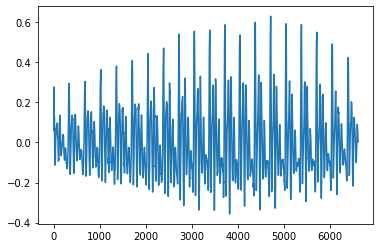

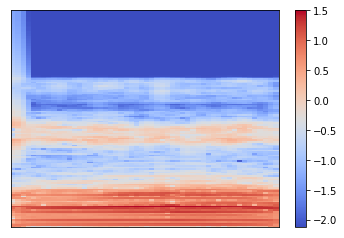

In [12]:
# normal
x, fs = load_wave_data(audios, master_csv.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)
ipd.Audio(x, rate=fs)


wave size:(6615,)
melsp size:(128, 52)
samping rate:44100


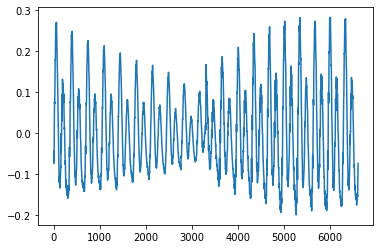

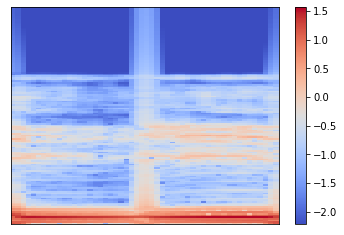

In [13]:
# shift_sound
x, fs = load_wave_data(audios, master_csv.loc[1,"filename"])
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)
ipd.Audio(x, rate=fs)

wave size:(6615,)
melsp size:(128, 52)
samping rate:44100


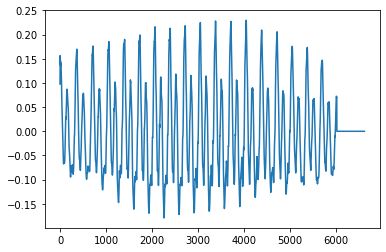

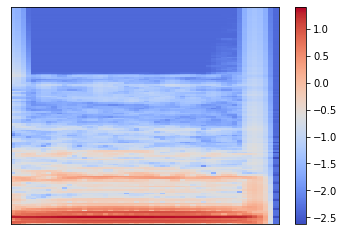

In [14]:
# stretch_sound
x, fs = load_wave_data(audios, master_csv.loc[2,"filename"])
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)
ipd.Audio(x, rate=fs)

In [15]:
# get training dataset and target dataset
x = list(master_csv.loc[:,"filename"])
y = list(master_csv.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x,
                                                                    y,
                                                                    test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train),
                                                                len(x_test),
                                                                len(y_test)))
print()
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train,
                                                                y_train,
                                                                x_test,
                                                                y_test))

x train:187
y train:187
x test:63
y test:63

x train:['rec08-012.wav', 'rec02-011.wav', 'rec05-020.wav', 'rec02-013.wav', 'rec09-023.wav', 'rec11-001.wav', 'rec10-013.wav', 'rec07-000.wav', 'rec07-008.wav', 'rec01-012.wav', 'rec08-019.wav', 'rec03-008.wav', 'rec09-011.wav', 'rec08-004.wav', 'rec01-020.wav', 'rec06-021.wav', 'rec07-003.wav', 'rec08-005.wav', 'rec01-017.wav', 'rec02-001.wav', 'rec08-000.wav', 'rec09-019.wav', 'rec07-021.wav', 'rec06-000.wav', 'rec11-014.wav', 'rec05-004.wav', 'rec06-009.wav', 'rec11-018.wav', 'rec02-005.wav', 'rec01-004.wav', 'rec08-022.wav', 'rec08-006.wav', 'rec06-010.wav', 'rec11-006.wav', 'rec08-011.wav', 'rec09-010.wav', 'rec05-010.wav', 'rec07-010.wav', 'rec08-014.wav', 'rec11-019.wav', 'rec08-021.wav', 'rec08-001.wav', 'rec02-018.wav', 'rec10-015.wav', 'rec08-017.wav', 'rec07-012.wav', 'rec01-016.wav', 'rec01-011.wav', 'rec09-021.wav', 'rec09-016.wav', 'rec02-022.wav', 'rec05-011.wav', 'rec03-001.wav', 'rec10-019.wav', 'rec07-006.wav', 'rec05-000.

#### 各カテゴリ毎のカウント数を表示

In [16]:
a = np.zeros(5)
for c in y_test:
    a[c] += 1
print(a)

[12. 13. 13. 12. 13.]


### npzファイル生成用関数 save_np_data

In [17]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    '''

    :param filename : filename save as
    :param x : filename of wav
    :param y : class label data
    :param aug : func pointer aug()
    :param rates : option if aug()
    :return : void

    save npzfile
    '''
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(x)):
        _x, fs = load_wave_data(audios, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

### npzファイルの生成

In [18]:
# 周波数を128に
# 時間を52に設定
freq = 128
time = 52

###　生成ファイル一覧

test_data_set.npz

train_data_set_clean.npz

train_data_set_whitenoise.npz

train_data_set_soundshift.npz

train_data_set_stretch.npz

In [19]:
# save test dataset
if not os.path.exists("test_data_set.npz"):
    save_np_data("test_data_set.npz",
                 x_test,
                 y_test)

# save raw training dataset
if not os.path.exists("train_data_set_clean.npz"):
    save_np_data("train_data_set_clean.npz",
                 x_train,
                 y_train)

# save training dataset with white noise
if not os.path.exists("train_data_set_whitenoise.npz"):
    rates = np.random.randint(1,5,len(x_train))/10000
    save_np_data("train_data_set_whitenoise.npz",
                 x_train,
                 y_train,
                 aug=add_white_noise, rates=rates)

# save training dataset with sound shift
if not os.path.exists("train_data_set_soundshift.npz"):
    rates = np.random.choice(np.arange(2,6),len(x_train))
    save_np_data("train_data_set_soundshift.npz",
                 x_train,
                 y_train,
                 aug=shift_sound, rates=rates)

# save training dataset with stretch
if not os.path.exists("train_data_set_stretch.npz"):
    rates = np.random.choice(np.arange(80,120),len(x_train))/100
    save_np_data("train_data_set_stretch.npz",
                 x_train,
                 y_train,
                 aug=stretch_sound,
                 rates=rates)

if not os.path.exists("train_data_effected.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audios, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,5)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("train_data_effected.npz", x=np_data, y=np_targets)

In [20]:
train_files = ["train_data_set_clean.npz",
               "train_data_set_whitenoise.npz",
               "train_data_set_soundshift.npz",
               "train_data_set_stretch.npz"]

test_file = "test_data_set.npz"

data = np.load(train_files[0])
print("data[x] shape:{0}\n{1}".format(data["x"].shape, data["x"]))
print()
print("data[y] shape:{0}\n{1}".format(data["y"].shape, data["y"]))



data[x] shape:(187, 128, 52)
[[[ 0.88202107  0.8005898   0.54496205 ...  0.20164135  0.46030253
    0.60934669]
  [ 0.96363997  0.94336557  0.87446105 ...  0.6241048   0.65712976
    0.57154536]
  [ 0.6445927   0.50389528  0.65005076 ...  0.7296074   0.65013587
    0.45340842]
  ...
  [-1.51630056 -1.58018827 -1.79596257 ... -2.2661202  -1.98013318
   -1.82048893]
  [-1.51925659 -1.58311903 -1.7988081  ... -2.26522589 -1.98287928
   -1.82329798]
  [-1.52066922 -1.58449888 -1.80007672 ... -2.26405668 -1.98403943
   -1.82454038]]

 [[ 0.87156236  0.80645365  0.58001441 ...  0.32601342  0.75963646
    0.95387059]
  [ 0.98232734  0.96524143  0.870103   ...  1.03611755  1.06454253
    0.97683734]
  [ 0.64561915  0.86884069  1.01229191 ...  1.18819523  1.15010643
    1.01127791]
  ...
  [-1.4644146  -1.52830243 -1.74407673 ... -2.2695632  -2.2695632
   -2.2695632 ]
  [-1.46730733 -1.53116965 -1.74685884 ... -2.26866746 -2.26866746
   -2.26866746]
  [-1.46869755 -1.53252697 -1.74810481 ... -2